# Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

2025-07-24 20:16:34.966224: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-24 20:16:35.118535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753368395.190010   13370 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753368395.210210   13370 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753368395.335820   13370 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

# Loading Data

In [4]:
import os
from PIL import Image
import pandas as pd

image_dir = "/home/jay/Face_Analysis/datasets/age_prediction/crop_part1"


images = []
ages = []
genders = []

# Loop through images
for filename in os.listdir(image_dir)[:8000]:
    try:
        age, gender = map(int, filename.split("_")[:2])
        img_path = os.path.join(image_dir, filename)
        img = Image.open(img_path).convert("RGB")

        ages.append(age)
        genders.append(gender)
        images.append(img)

    except Exception as e:
        print(f"Skipping file {filename}: {e}")

# Create a DataFrame
df = pd.DataFrame({
    "Images": images,
    "Ages": ages,
    "Genders": genders
})

df.head()


,Images,Ages,Genders
0,<PIL.Image.Image image mode=RGB size=200x200 a...,85,1
1,<PIL.Image.Image image mode=RGB size=200x200 a...,4,1
2,<PIL.Image.Image image mode=RGB size=200x200 a...,2,1
3,<PIL.Image.Image image mode=RGB size=200x200 a...,4,1
4,<PIL.Image.Image image mode=RGB size=200x200 a...,4,1


In [5]:
df['Genders'].value_counts()

Genders
1    4461
0    3539
Name: count, dtype: int64

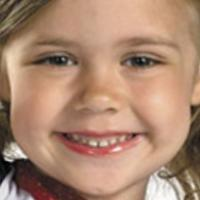

4 1


In [6]:
display(df['Images'][1])
print(df['Ages'][1],df['Genders'][1])

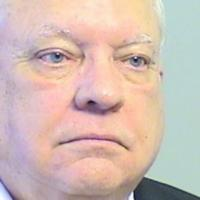

66 0


In [7]:
display(df['Images'][7000])
print(df['Ages'][7000], df['Genders'][7000])

#  Visualising and Preparing Data

<Axes: xlabel='Ages', ylabel='Count'>

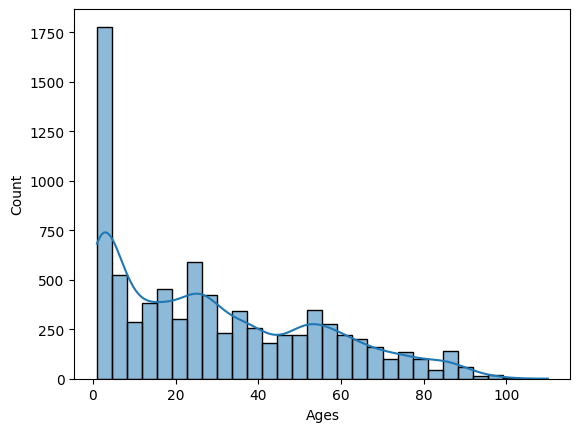

In [8]:
sns.histplot(df['Ages'],kde=True,bins=30)

In [9]:
under4s = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4s.append(df.iloc[i])
under4s = pd.DataFrame(under4s)
under4s = under4s.sample(frac = 0.3)

df = df[df['Ages'] > 4]
df = pd.concat([df,under4s],ignore_index = True)

<Axes: xlabel='Ages', ylabel='Count'>

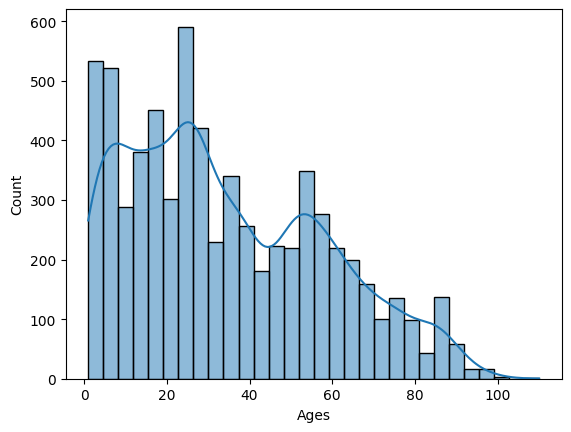

In [10]:
sns.histplot(df['Ages'],kde=True, bins=30)

In [11]:
df = df[df['Ages'] < 80]

<Axes: xlabel='Ages', ylabel='Count'>

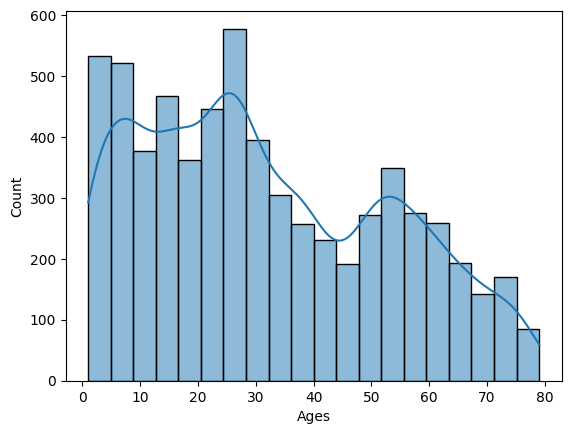

In [12]:
sns.histplot(df['Ages'],kde=True, bins=20)

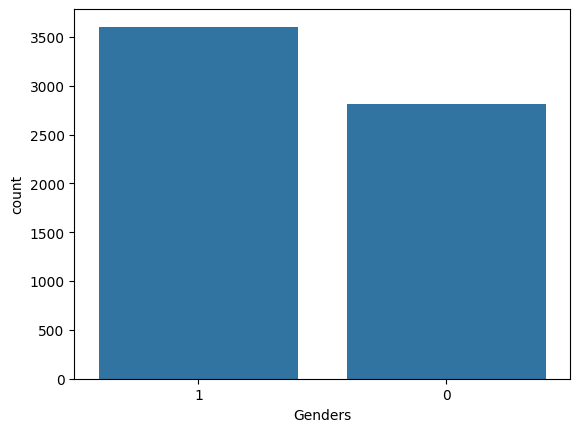

In [13]:
sns.countplot(data=df,x='Genders', order=df.Genders.value_counts().index)
plt.show()

In [14]:
# Reset index to avoid KeyError
df = df.reset_index(drop=True)

x = []
y = []

for i in range(len(df)):
    try:
        img = df.loc[i, 'Images']

        # Make sure the image is a PIL image
        if not isinstance(img, Image.Image):
            print(f"Skipping index {i}: Not an image object")
            continue

        # Resize safely
        resized = img.copy().resize((200, 200), Image.Resampling.LANCZOS)
        ar = np.asarray(resized)

        x.append(ar)
        y.append([int(df.loc[i, 'Ages']), int(df.loc[i, 'Genders'])])

    except Exception as e:
        print(f" Skipping index {i} due to error: {type(e).__name__} - {e}")

x = np.array(x)
y = np.array(y)



In [15]:
print("X shape:", x.shape)
print("Y shape:", y.shape)

X shape: (6416, 200, 200, 3)
Y shape: (6416, 2)


# Train Test Split

In [16]:
y_age = df['Ages']
y_gender = df['Genders']

x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(x, y_age, test_size=0.2, stratify=y_age)
x_train_gender, x_test_gender, y_train_gender, y_test_gender = train_test_split(x, y_gender, test_size=0.2, stratify=y_gender)

# Creating the Models

In [18]:
agemodel = Sequential()
agemodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(64, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Conv2D(128, (3,3), activation='relu'))
agemodel.add(MaxPooling2D((2,2)))
agemodel.add(Flatten())
agemodel.add(Dense(64, activation='relu'))
agemodel.add(Dropout(0.5))
agemodel.add(Dense(1, activation='relu'))

agemodel.compile(loss='mean_squared_error',
             optimizer=optimizers.Adam(learning_rate=0.0001))

genmodel = Sequential()
genmodel.add(Conv2D(32, (3,3), activation='relu', input_shape=(200, 200, 3)))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(64, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Conv2D(128, (3,3), activation='relu'))
genmodel.add(MaxPooling2D((2,2)))
genmodel.add(Flatten())
genmodel.add(Dense(64, activation='relu'))
genmodel.add(Dropout(0.5))
genmodel.add(Dense(1, activation='sigmoid'))

genmodel.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.0001),
             metrics=['accuracy'])

# Training the Models

In [19]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train1 = datagen.flow(x_train_age, y_train_age, batch_size=32)

test1 = test_datagen.flow(
        x_test_age, y_test_age,
        batch_size=32)

history1 = agemodel.fit(train1, epochs=50, shuffle=True, validation_data=test1)

/home/jay/my-jupyter-env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 75s 457ms/step - loss: 809.9821 - val_loss: 468.2480
Epoch 2/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 71s 437ms/step - loss: 515.3595 - val_loss: 440.6754
Epoch 3/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 70s 437ms/step - loss: 489.3388 - val_loss: 390.4327
Epoch 4/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 71s 441ms/step - loss: 435.9854 - val_loss: 331.4198
Epoch 5/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 72s 446ms/step - loss: 409.3346 - val_loss: 312.2690
Epoch 6/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 73s 451ms/step - loss: 393.6668 - val_loss: 330.4771
Epoch 7/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 68s 425ms/step - loss: 399.8145 - val_loss: 343.9279
Epoch 8/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 69s 425ms/step - loss: 372.9607 - val_loss: 294.1585
Epoch 9/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 70s 436ms/step - loss: 369.6834 - val_loss: 284.6798
Epoch 10/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 70s 434ms/step - loss: 358.1574 - val_loss: 290.2545
Epoch 11/50
161/161 ━━━━━━━━━━━━━━━━━━━━ 70s 434ms/step - loss: 356.9

In [20]:
datagen = ImageDataGenerator(
      rescale=1./255., width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale=1./255)

train2 = datagen.flow(x_train_gender, y_train_gender, batch_size=64)

test2 = test_datagen.flow(
        x_test_gender, y_test_gender,
        batch_size=64)

history2 = genmodel.fit(train2, epochs=50, shuffle=True, validation_data=test2)

Epoch 1/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 74s 887ms/step - accuracy: 0.5870 - loss: 0.6695 - val_accuracy: 0.7204 - val_loss: 0.5779
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 848ms/step - accuracy: 0.6722 - loss: 0.6122 - val_accuracy: 0.7212 - val_loss: 0.5627
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 70s 856ms/step - accuracy: 0.7059 - loss: 0.5714 - val_accuracy: 0.7461 - val_loss: 0.5253
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 857ms/step - accuracy: 0.7347 - loss: 0.5399 - val_accuracy: 0.7586 - val_loss: 0.5094
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 848ms/step - accuracy: 0.7657 - loss: 0.5083 - val_accuracy: 0.7679 - val_loss: 0.4773
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 69s 846ms/step - accuracy: 0.7748 - loss: 0.4967 - val_accuracy: 0.7718 - val_loss: 0.4635
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 71s 875ms/step - accuracy: 0.7712 - loss: 0.4789 - val_accuracy: 0.7671 - val_loss: 0.4561
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 72s 886ms/step - accuracy: 0.7844 - loss: 0.4666 - val_accu

# Evaluating the Model

In [21]:
def process_and_predict(file):
    im = Image.open(file).convert("RGB")  # Ensure 3 channels
    
    # Square crop
    width, height = im.size
    if width != height:
        if width > height:
            left = (width - height) / 2
            right = left + height
            im = im.crop((left, 0, right, height))
        else:
            top = (height - width) / 2
            bottom = top + width
            im = im.crop((0, top, width, bottom))

    im = im.resize((200, 200), Image.Resampling.LANCZOS)

    # Prepare for model
    ar = np.asarray(im).astype("float32") / 255.0
    ar = ar.reshape(1, 200, 200, 3)

    # Predictions
    age_pred = int(agemodel.predict(ar)[0][0])
    gender_pred = int(np.round(genmodel.predict(ar)[0][0]))
    gender = "male" if gender_pred == 0 else "female"

    print(f"Age: {age_pred}\nGender: {gender}")

    return im.resize((300, 300), Image.Resampling.LANCZOS)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Age: 29
Gender: female


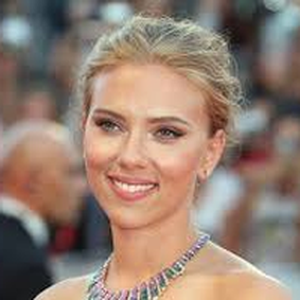

In [22]:
process_and_predict('../datasets/age_prediction_test/female.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Age: 28
Gender: female


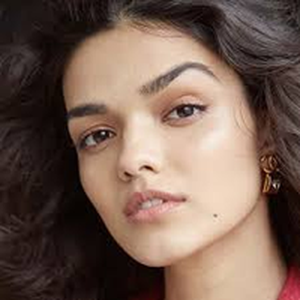

In [23]:
process_and_predict('../datasets/age_prediction_test/female_2.jpeg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Age: 52
Gender: male


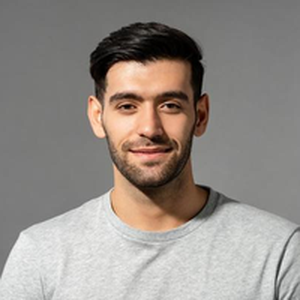

In [24]:
process_and_predict('../datasets/age_prediction_test/men.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Age: 40
Gender: male


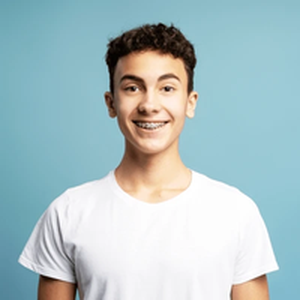

In [25]:
process_and_predict('../datasets/age_prediction_test/teen.webp')

In [28]:
agemodel.save("saved_models/age_model.keras")

In [29]:
genmodel.save("saved_models/gender_model.keras")